In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iisignature
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score

#btc = yf.download('BTC-USD', start='2014-09-17', end='2024-12-31', interval='1d', timeout=60, progress=False, threads=False)

btc = pd.read_csv('BTC-USD.csv', index_col=0, parse_dates=True)
btc = btc[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].dropna() # 确保所有列都在
#btc = btc[['Close', 'Volume']].dropna()

#price = btc['Adj Close'].values
#volume = btc['Volume'].values

price = np.log(btc['Adj Close']).values
volume = np.log(btc['Volume']).values

#btc = btc[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].dropna() # 确保所有列都在

## 示例：计算对数价格和对数成交量
#btc['Log_Close'] = np.log(btc['Close'])
#btc['Log_Volume'] = np.log(btc['Volume'])

# 示例：计算每日价格范围
#btc['Daily_Range'] = btc['High'] - btc['Low']

timestamps = np.linspace(0, 1, len(price)) 



MMD² between rising and other segments (gamma=0.0006): 0.548778


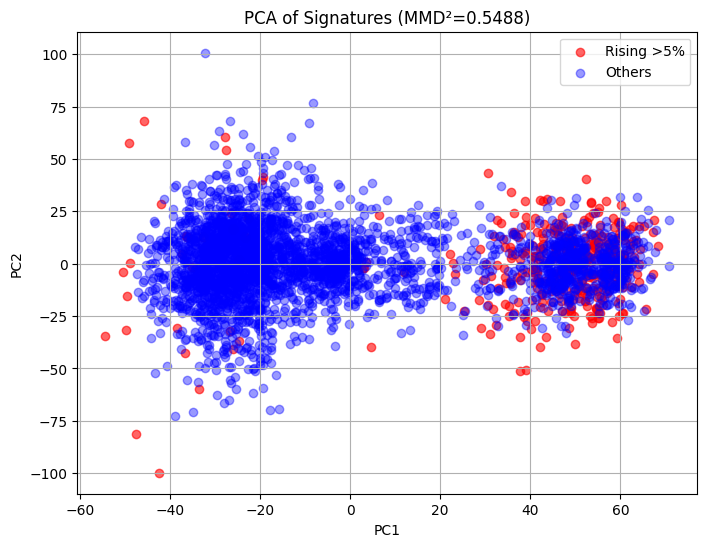

In [7]:
# Transformations
def lead_lag_transform(x):
    x_repeated = np.repeat(x, 2, axis=0)
    lead = x_repeated[1:]
    lag = x_repeated[:-1]
    return np.concatenate([lead, lag], axis=1)

def cumulative_sum(path):
    return np.cumsum(path, axis=0)

def time_integrated(path, ts):
    ts_scaled = np.interp(ts, (ts.min(), ts.max()), (0, 1))
    ts_expanded = np.interp(np.linspace(0, len(ts_scaled)-1, len(path)), np.arange(len(ts_scaled)), ts_scaled)
    return np.column_stack([path, ts_expanded])

def invisibility_reset(path):
    last = path[-1]
    reset_path = np.vstack([path, last, np.zeros_like(last)])
    flag = np.vstack([np.zeros((len(path), 1)), np.ones((2, 1))])
    return np.hstack([reset_path, flag])

def build_signature_path(price, volume, ts):
    path = np.column_stack([price, volume])
    path = lead_lag_transform(path)
    path = cumulative_sum(path)
    path = time_integrated(path, ts)
    path = invisibility_reset(path)
    return path


# Window = 7 and Calculate the signature
def extract_signatures(price, volume, window=7, sig_order=3):
    signatures = []
    labels = []
    for i in range(len(price) - window + 1):
        p_slice = price[i:i+window]
        v_slice = volume[i:i+window]

        # label: up 5%
        price_arr = np.array(p_slice)
        min_prices = np.minimum.accumulate(price_arr[::-1])[::-1]  # 滑动最小值
        pct_changes = (price_arr - min_prices) / min_prices
        max_pct_change = np.max(pct_changes)
        is_rising = max_pct_change >= 0.05
        labels.append(is_rising)

        # Signature Path 
        ts = np.arange(window)
        path = build_signature_path(p_slice, v_slice, ts)
        sig = iisignature.sig(path, sig_order)
        signatures.append(sig)

    return np.array(signatures), np.array(labels)

#calculate MMD and PCA
def analyze_signature_diff_mmd(signatures, labels, gamma=None, visualize=True):
    scaler = StandardScaler()
    sigs_scaled = scaler.fit_transform(signatures)

    sig_pos = sigs_scaled[labels]
    sig_neg = sigs_scaled[~labels]

    # define gamma
    if gamma is None:
        gamma = 1.0 / sigs_scaled.shape[1]

    # RBF MMD
    K_xx = rbf_kernel(sig_pos, sig_pos, gamma=gamma)
    K_yy = rbf_kernel(sig_neg, sig_neg, gamma=gamma)
    K_xy = rbf_kernel(sig_pos, sig_neg, gamma=gamma)

    m, n = len(sig_pos), len(sig_neg)
    mmd2 = K_xx.sum() / (m*m) + K_yy.sum() / (n*n) - 2 * K_xy.sum() / (m*n)

    print(f"MMD² between rising and other segments (gamma={gamma:.4f}): {mmd2:.6f}")

    # CPA visualisation
    if visualize:
        X_pca = PCA(n_components=2).fit_transform(sigs_scaled)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], c='red', label='Rising >5%', alpha=0.6)
        plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], c='blue', label='Others', alpha=0.4)
        plt.title(f"PCA of Signatures (MMD²={mmd2:.4f})")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == "__main__":

    signatures, labels = extract_signatures(price, volume, window=7, sig_order=4)

    analyze_signature_diff_mmd(signatures, labels, gamma=None)



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
import iisignature

# -----------------------
# Signature Pipeline
# -----------------------
class SignaturePipeline:
    def __init__(self, window=7, sig_order=3, gamma=None):
        self.window = window
        self.sig_order = sig_order
        self.gamma = gamma
        self.scaler = StandardScaler()

    @staticmethod
    def lead_lag_transform(x):
        x_repeated = np.repeat(x, 2, axis=0)
        lead = x_repeated[1:]
        lag = x_repeated[:-1]
        return np.concatenate([lead, lag], axis=1)

    @staticmethod
    def cumulative_sum(path):
        return np.cumsum(path, axis=0)

    @staticmethod
    def time_integrated(path, ts):
        ts_scaled = np.interp(ts, (ts.min(), ts.max()), (0, 1))
        ts_expanded = np.interp(np.linspace(0, len(ts_scaled)-1, len(path)), np.arange(len(ts_scaled)), ts_scaled)
        return np.column_stack([path, ts_expanded])

    @staticmethod
    def invisibility_reset(path):
        last = path[-1]
        reset_path = np.vstack([path, last, np.zeros_like(last)])
        flag = np.vstack([np.zeros((len(path), 1)), np.ones((2, 1))])
        return np.hstack([reset_path, flag])

    def build_signature_path(self, price, volume, ts):
        path = np.column_stack([price, volume])
        path = self.lead_lag_transform(path)
        path = self.cumulative_sum(path)
        path = self.time_integrated(path, ts)
        path = self.invisibility_reset(path)
        return path

    def extract_signatures(self, price, volume):
        signatures, labels, pct_changes = [], [], []
        for i in range(len(price) - self.window + 1):
            p_slice = price[i:i+self.window]
            v_slice = volume[i:i+self.window]

            price_arr = np.array(p_slice)
            min_prices = np.minimum.accumulate(price_arr[::-1])[::-1]  # 滑动最小值
            pct_changes = (price_arr - min_prices) / min_prices
            max_pct_change = np.max(pct_changes)
            is_rising = max_pct_change >= 0.05
            labels.append(is_rising)
            pct_changes.append(pct_change)

            ts = np.arange(self.window)
            path = self.build_signature_path(p_slice, v_slice, ts)
            sig = iisignature.sig(path, self.sig_order)
            signatures.append(sig)

        return np.array(signatures), np.array(labels), np.array(pct_changes)

# -----------------------
# Scoring Rule - batch (full score map)
# -----------------------
def scoring_rule_similarity_filter(signatures, ref_indices, gamma=None):
    sigs_scaled = StandardScaler().fit_transform(signatures)
    X = sigs_scaled
    P = X[ref_indices]
    m = len(ref_indices)

    if gamma is None:
        gamma = 1.0 / X.shape[1]

    K_PP = rbf_kernel(P, P, gamma=gamma)
    np.fill_diagonal(K_PP, 0)
    mean_inner = K_PP.sum() / (m * (m - 1))

    K_PY = rbf_kernel(P, X, gamma=gamma)
    mean_cross = (2 / m) * K_PY.sum(axis=0)

    scores = mean_inner - mean_cross
    return scores

# -----------------------
# Scoring Rule - single y
# -----------------------
def scoring_rule_single_point(y_sig, dist_sigs, gamma=None):
    m = len(dist_sigs)
    if gamma is None:
        gamma = 1.0 / dist_sigs.shape[1]

    K_PP = rbf_kernel(dist_sigs, dist_sigs, gamma=gamma)
    np.fill_diagonal(K_PP, 0)
    mean_inner = K_PP.sum() / (m * (m - 1))

    K_y = rbf_kernel(dist_sigs, y_sig.reshape(1, -1), gamma=gamma)  # shape (m, 1)
    mean_cross = (2 / m) * K_y.sum()

    score = mean_inner - mean_cross
    return score

# -----------------------
# Visualization
# -----------------------
def plot_price_with_scored_segments(price, timestamps, similar_idxs, ref_idx, window=7):
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, price, color='black', linewidth=1, label='Price')

    ymax = price.max()
    for idx in similar_idxs:
        start = idx
        end = idx + window
        if end < len(price):
            mid = (timestamps[start] + timestamps[end]) / 2
            plt.axvspan(timestamps[start], timestamps[end], color='orange', alpha=0.3)

    start = ref_idx
    end = ref_idx + window
    plt.axvspan(timestamps[start], timestamps[end], color='green', alpha=0.4, label='Reference Segment')
    mid = (timestamps[start] + timestamps[end]) / 2
    plt.text(mid, ymax * 1.02, "Reference Segment", ha='center', fontsize=9, weight='bold', color='green')

    plt.title("Price Chart - Segments Similar to Reference Distribution (Scoring Rule)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------
# Data Loader
# -----------------------
def load_btc_data(filepath='BTC-USD.csv'):
    btc = pd.read_csv(filepath, index_col=0, parse_dates=True)
    btc = btc[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].dropna() # 确保所有列都在
#btc = btc[['Close', 'Volume']].dropna()

#price = btc['Adj Close'].values
#volume = btc['Volume'].values

    price = np.log(btc['Volume']).values
    volume = np.log(btc['Volume']).values
    return price, volume

# -----------------------
# Main
# -----------------------
if __name__ == "__main__":
    price, volume = load_btc_data()
    timestamps = np.linspace(0, 1, len(price))

    pipeline = SignaturePipeline(window=7, sig_order=4)
    signatures, labels, pct_changes = pipeline.extract_signatures(price, volume)
    sigs_scaled = StandardScaler().fit_transform(signatures)

    # Max rising window
    ref_idx = np.argmax(pct_changes)
    print(f"Max rise: {pct_changes[ref_idx]*100:.2f}% at index {ref_idx}")

    # Reference distribution: all windows with >5% rise
    rising_indices = np.where(pct_changes >= 0.05)[0]
    rising_sigs = sigs_scaled[rising_indices]

    # Scoring: all windows against rising distribution
    scores_all = [scoring_rule_single_point(sigs_scaled[i], rising_sigs) for i in range(len(sigs_scaled))]
    scores_all = np.array(scores_all)

    # Visualize: scatter plot of score, colored by label
    plt.figure(figsize=(12, 4))
    colors = ['green' if l else 'gray' for l in labels]
    plt.scatter(np.arange(len(scores_all)), scores_all, c=colors, alpha=0.6)
    plt.axhline(np.percentile(scores_all, 5), linestyle='--', color='red', label='5% Score Threshold')
    plt.title("Scoring Rule: Each Window vs Rising Distribution")
    plt.xlabel("Window Index")
    plt.ylabel("Score (lower = more similar)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: highlight top 3% most similar windows
    threshold_score = np.percentile(scores_all, 3)
    similar_idxs = np.where(scores_all <= threshold_score)[0]

    # Visualize similar segments on price chart
    plot_price_with_scored_segments(price, timestamps, similar_idxs, ref_idx, window=pipeline.window)

    # Score of specific reference window
    ref_score = scoring_rule_single_point(sigs_scaled[ref_idx], rising_sigs)
    print(f"Score of max-rising window vs rising distribution: {ref_score:.6f}")


AttributeError: 'numpy.ndarray' object has no attribute 'append'

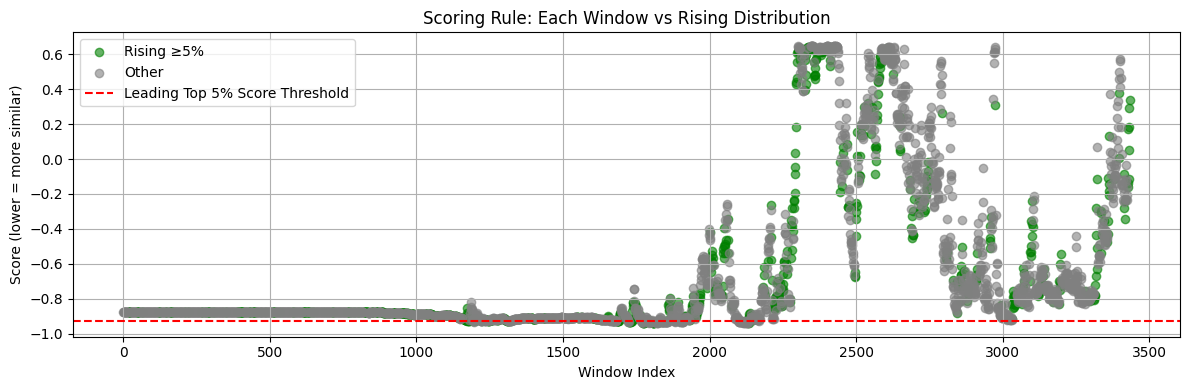

<Figure size 640x480 with 0 Axes>

In [65]:
plt.figure(figsize=(12, 4))


idx_up = np.where(labels == 1)[0]
idx_down = np.where(labels == 0)[0]

plt.scatter(idx_up, scores_all[idx_up], c='green', alpha=0.6, label='Rising ≥5%')

plt.scatter(idx_down, scores_all[idx_down], c='gray', alpha=0.6, label='Other')


plt.axhline(np.percentile(scores_all, 5), linestyle='--', color='red', label='Leading Top 5% Score Threshold')


plt.title("Scoring Rule: Each Window vs Rising Distribution")
plt.xlabel("Window Index")
plt.ylabel("Score (lower = more similar)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("scoring_Rule.pdf")


🔍 MMD² (RBF kernel, gamma=0.03): 0.0015


/Users/zheguan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:106: RuntimeWarning: overflow encountered in cast
  distances_data = distances_data.astype(np.float32, copy=False)
/Users/zheguan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


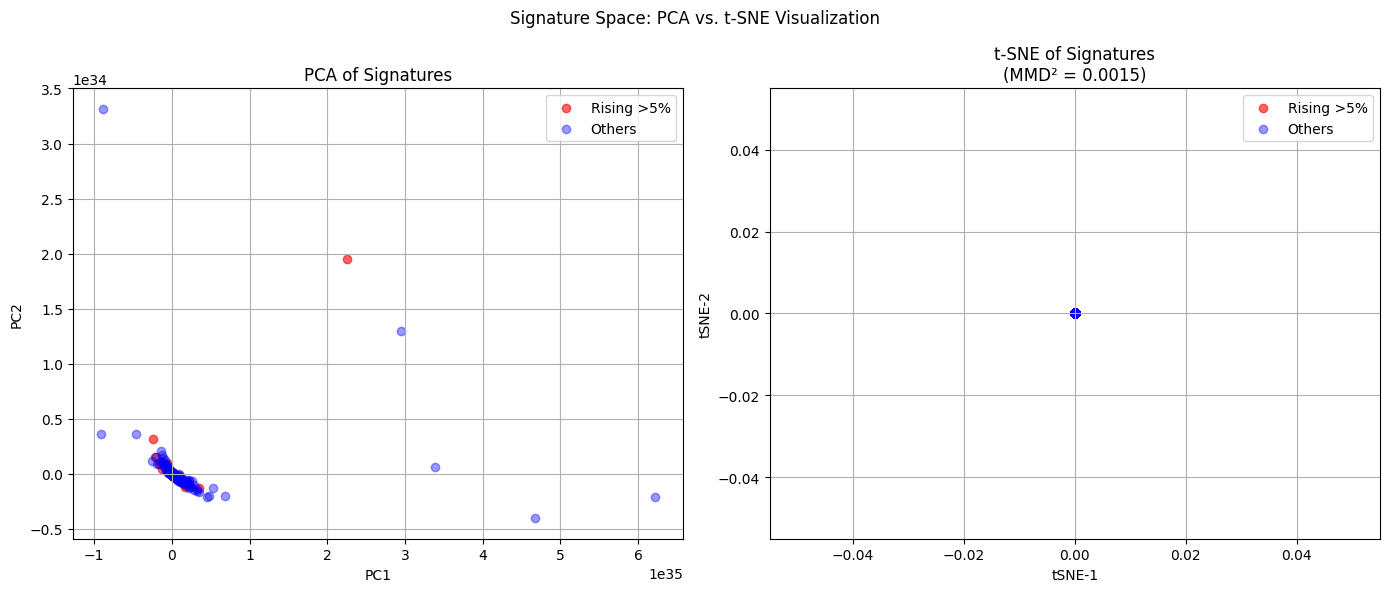

In [37]:
visualize_signature_pca_tsne(signatures, labels, gamma=0.03, perplexity=30)

Max rise: 83.52% at index 1997


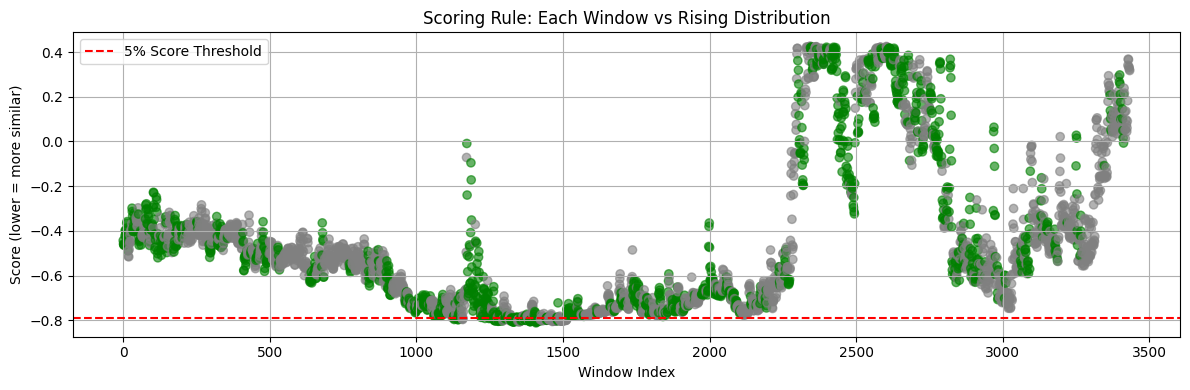

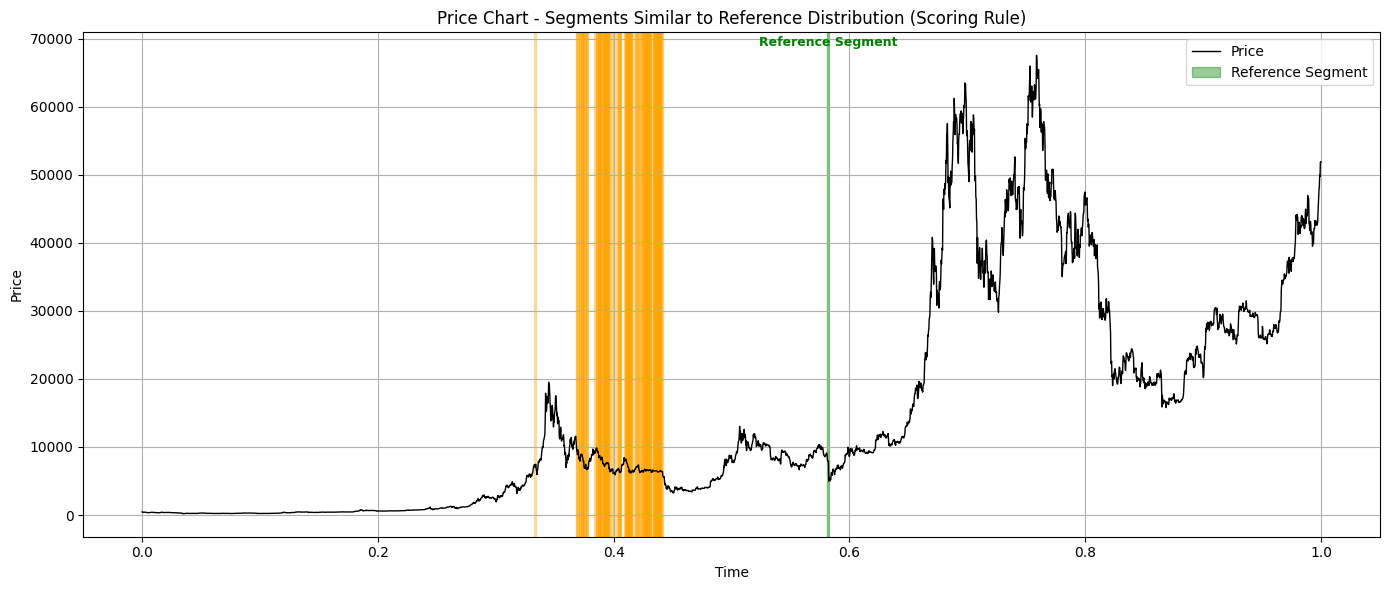

Score of max-rising window vs rising distribution: -0.469738


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances # 引入 euclidean_distances
import iisignature

# -----------------------
# Signature Pipeline
# -----------------------
class SignaturePipeline:
    def __init__(self, window=7, sig_order=3, gamma=None):
        self.window = window
        self.sig_order = sig_order
        self.gamma = gamma
        self.scaler = StandardScaler()

    @staticmethod
    def lead_lag_transform(x):
        x_repeated = np.repeat(x, 2, axis=0)
        lead = x_repeated[1:]
        lag = x_repeated[:-1]
        return np.concatenate([lead, lag], axis=1)

    @staticmethod
    def cumulative_sum(path):
        return np.cumsum(path, axis=0)

    @staticmethod
    def time_integrated(path, ts):
        ts_scaled = np.interp(ts, (ts.min(), ts.max()), (0, 1))
        ts_expanded = np.interp(np.linspace(0, len(ts_scaled)-1, len(path)), np.arange(len(ts_scaled)), ts_scaled)
        return np.column_stack([path, ts_expanded])

    @staticmethod
    def invisibility_reset(path):
        last = path[-1]
        reset_path = np.vstack([path, last, np.zeros_like(last)])
        flag = np.vstack([np.zeros((len(path), 1)), np.ones((2, 1))])
        return np.hstack([reset_path, flag])

    def build_signature_path(self, price_slice, volume_slice, ts): # 修改参数名为 _slice 更明确
        # 如果你想将更多特征加入路径，这里需要调整
        # 例如：data_slice = np.column_stack([price_slice, volume_slice, open_slice, high_slice, low_slice])
        # 然后 path = data_slice
        path = np.column_stack([price_slice, volume_slice]) # 目前只使用了价格和成交量
        path = self.lead_lag_transform(path)
        path = self.cumulative_sum(path)
        path = self.time_integrated(path, ts)
        path = self.invisibility_reset(path)
        return path

    def extract_signatures(self, price, volume):
        signatures = []
        labels = []
        max_pct_changes_list = [] # <-- 修改1：为了清晰，重命名这个列表

        for i in range(len(price) - self.window + 1):
            p_slice = price[i:i+self.window]
            v_slice = volume[i:i+self.window]

            price_arr = np.array(p_slice)
            min_prices = np.minimum.accumulate(price_arr[::-1])[::-1]  # 滑动最小值
            
            # 计算窗口内的所有百分比变化（这是一个数组）
            pct_changes_in_window = (price_arr - min_prices) / min_prices
            max_pct_change = np.max(pct_changes_in_window) # 获取这个窗口内的最大百分比变化
            
            is_rising = max_pct_change >= 0.05
            labels.append(is_rising)
            max_pct_changes_list.append(max_pct_change) # <-- 修改2：将 max_pct_change 添加到列表中

            ts = np.arange(self.window)
            path = self.build_signature_path(p_slice, v_slice, ts)
            sig = iisignature.sig(path, self.sig_order)
            signatures.append(sig)

        return np.array(signatures), np.array(labels), np.array(max_pct_changes_list)

# -----------------------
# Scoring Rule - batch (full score map)
# -----------------------
def scoring_rule_similarity_filter(signatures, ref_indices, gamma=None):
    sigs_scaled = StandardScaler().fit_transform(signatures)
    X = sigs_scaled
    P = X[ref_indices]
    m = len(ref_indices)

    if m == 0 or m == 1: # Added check for insufficient reference points
        return np.zeros(len(X)) # Return all zeros if no reference or only one

    if gamma is None:
        gamma = 1.0 / X.shape[1]

    K_PP = rbf_kernel(P, P, gamma=gamma)
    np.fill_diagonal(K_PP, 0)
    mean_inner = K_PP.sum() / (m * (m - 1))

    K_PY = rbf_kernel(P, X, gamma=gamma)
    mean_cross = (2 / m) * K_PY.sum(axis=0)

    scores = mean_inner - mean_cross
    return scores

# -----------------------
# Scoring Rule - single y
# -----------------------
def scoring_rule_single_point(y_sig, dist_sigs, gamma=None):
    m = len(dist_sigs)
    if m == 0 or m == 1: # Added check for insufficient reference points
        return np.nan # Cannot compute score with less than 2 reference points

    if gamma is None:
        gamma = 1.0 / dist_sigs.shape[1]

    K_PP = rbf_kernel(dist_sigs, dist_sigs, gamma=gamma)
    np.fill_diagonal(K_PP, 0)
    mean_inner = K_PP.sum() / (m * (m - 1))

    K_y = rbf_kernel(dist_sigs, y_sig.reshape(1, -1), gamma=gamma)  # shape (m, 1)
    mean_cross = (2 / m) * K_y.sum()

    score = mean_inner - mean_cross
    return score

# -----------------------
# Visualization
# -----------------------
def plot_price_with_scored_segments(price, timestamps, similar_idxs, ref_idx, window=7):
    plt.figure(figsize=(14, 6))
    plt.plot(timestamps, price, color='black', linewidth=1, label='Price')

    ymax = price.max()
    for idx in similar_idxs:
        start = idx
        end = idx + window
        if end < len(price):
            # 修正：确保时间戳索引在范围内
            if start < len(timestamps) and end <= len(timestamps):
                plt.axvspan(timestamps[start], timestamps[end], color='orange', alpha=0.3)

    start = ref_idx
    end = ref_idx + window
    if start < len(timestamps) and end <= len(timestamps): # 修正：确保参考段的时间戳索引在范围内
        plt.axvspan(timestamps[start], timestamps[end], color='green', alpha=0.4, label='Reference Segment')
        mid = (timestamps[start] + timestamps[end]) / 2
        plt.text(mid, ymax * 1.02, "Reference Segment", ha='center', fontsize=9, weight='bold', color='green')

    plt.title("Price Chart - Segments Similar to Reference Distribution (Scoring Rule)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------
# Data Loader
# -----------------------
def load_btc_data(filepath='BTC-USD.csv'):
    btc = pd.read_csv(filepath, index_col=0, parse_dates=True)
    btc = btc[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].dropna()
    
    # <-- 修改3：修正 price 和 volume 的赋值
    # 如果你想使用 Adj Close 作为价格，就用它
    price_data = btc['Adj Close'].values # 通常用调整后的收盘价
    # 如果你打算对成交量取对数，在这里取
    volume_data = np.log(btc['Volume'].values) # 常常对成交量取对数以使其分布更对称

    return price_data, volume_data

# -----------------------
# Main
# -----------------------
if __name__ == "__main__":
    price, volume = load_btc_data()
    timestamps = np.linspace(0, 1, len(price))

    pipeline = SignaturePipeline(window=7, sig_order=4)
    # <-- 修改4：接收正确返回的 max_pct_changes 列表
    signatures, labels, max_pct_changes = pipeline.extract_signatures(price, volume)
    
    # 检查签名是否为空
    if len(signatures) == 0:
        print("未提取到任何签名。请检查数据长度和窗口设置。")
    else:
        sigs_scaled = StandardScaler().fit_transform(signatures)

        # Max rising window
        # <-- 修改5：使用 max_pct_changes 来找到最大涨幅的窗口
        ref_idx = np.argmax(max_pct_changes)
        print(f"Max rise: {max_pct_changes[ref_idx]*100:.2f}% at index {ref_idx}")

        # Reference distribution: all windows with >5% rise
        # <-- 修改6：使用 max_pct_changes 来筛选上涨的窗口
        rising_indices = np.where(max_pct_changes >= 0.05)[0]
        
        # 确保 rising_sigs 不为空
        if len(rising_indices) < 2: # MMD需要至少两个点来计算内积项
            print("上涨类别的参考分布样本不足 (少于2个)。无法计算得分或可视化。")
            scores_all = np.full(len(sigs_scaled), np.nan) # 填充NaN
        else:
            rising_sigs = sigs_scaled[rising_indices]

            # Scoring: all windows against rising distribution
            # <-- 修改7：确保 scoring_rule_single_point 能够处理空或单点参考集
            scores_all = [scoring_rule_single_point(sigs_scaled[i], rising_sigs, gamma=pipeline.gamma) for i in range(len(sigs_scaled))]
            scores_all = np.array(scores_all)

        # Visualize: scatter plot of score, colored by label
        plt.figure(figsize=(12, 4))
        colors = ['green' if l else 'gray' for l in labels] # 这里的labels是根据max_pct_change计算的
        plt.scatter(np.arange(len(scores_all)), scores_all, c=colors, alpha=0.6)
        
        # 确保 scores_all 有效才能计算分位数
        if not np.all(np.isnan(scores_all)):
            plt.axhline(np.nanpercentile(scores_all, 5), linestyle='--', color='red', label='5% Score Threshold')
        
        plt.title("Scoring Rule: Each Window vs Rising Distribution")
        plt.xlabel("Window Index")
        plt.ylabel("Score (lower = more similar)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Optional: highlight top 3% most similar windows
        if not np.all(np.isnan(scores_all)):
            threshold_score = np.nanpercentile(scores_all, 3) # 使用nanpercentile处理可能的NaN
            similar_idxs = np.where(scores_all <= threshold_score)[0]
        else:
            similar_idxs = []

        # Visualize similar segments on price chart
        plot_price_with_scored_segments(price, timestamps, similar_idxs, ref_idx, window=pipeline.window)

        # Score of specific reference window
        if len(rising_indices) >= 2:
            ref_score = scoring_rule_single_point(sigs_scaled[ref_idx], rising_sigs, gamma=pipeline.gamma)
            print(f"Score of max-rising window vs rising distribution: {ref_score:.6f}")
        else:
            print("参考分布样本不足，无法计算 max-rising window 的得分。")